In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
#
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 93% 112M/121M [00:01<00:00, 106MB/s]  
100% 121M/121M [00:01<00:00, 85.2MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-expression-recognition-dataset.zip')
zip_ref.extractall('/content/kaggle/input/face-expression-recognition-dataset')
zip_ref.close()

In [ ]:
TRAIN_DIR = '/content/kaggle/input/face-expression-recognition-dataset/images/train/'
TEST_DIR = '/content/kaggle/input/face-expression-recognition-dataset/images/validation/'

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [ ]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
sad Completed
happy Completed
neutral Completed
disgust Completed
surprise Completed
fear Completed


,image,label
0,/content/kaggle/input/face-expression-recognit...,fear
1,/content/kaggle/input/face-expression-recognit...,happy
2,/content/kaggle/input/face-expression-recognit...,neutral
3,/content/kaggle/input/face-expression-recognit...,sad
4,/content/kaggle/input/face-expression-recognit...,surprise


In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
sad Completed
happy Completed
neutral Completed
disgust Completed
surprise Completed
fear Completed


,image,label
0,/content/kaggle/input/face-expression-recognit...,angry
1,/content/kaggle/input/face-expression-recognit...,angry
2,/content/kaggle/input/face-expression-recognit...,angry
3,/content/kaggle/input/face-expression-recognit...,angry
4,/content/kaggle/input/face-expression-recognit...,angry


<Axes: xlabel='label', ylabel='count'>

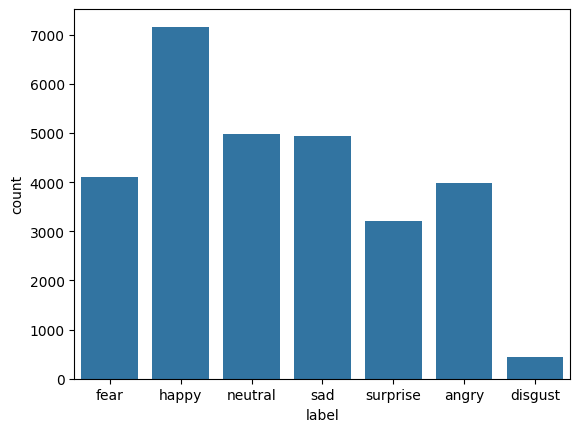

In [ ]:
sns.countplot(train , x = 'label' )

<Axes: xlabel='label', ylabel='count'>

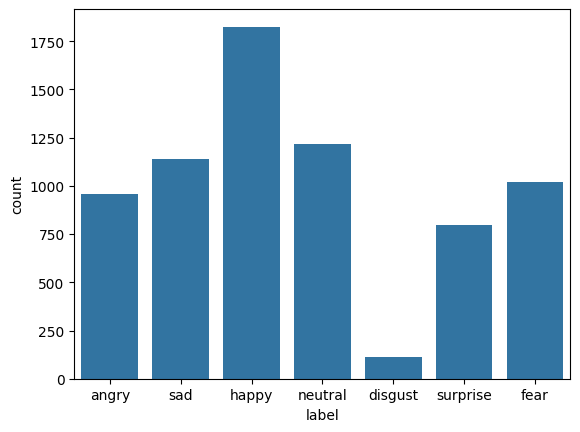

In [ ]:
sns.countplot(test, x='label')

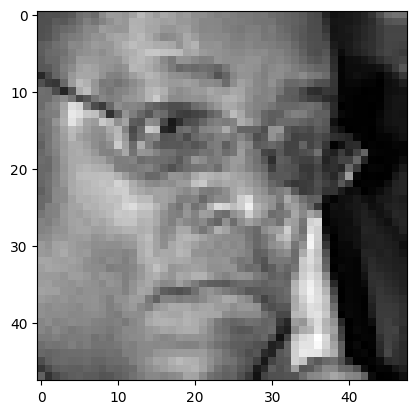

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

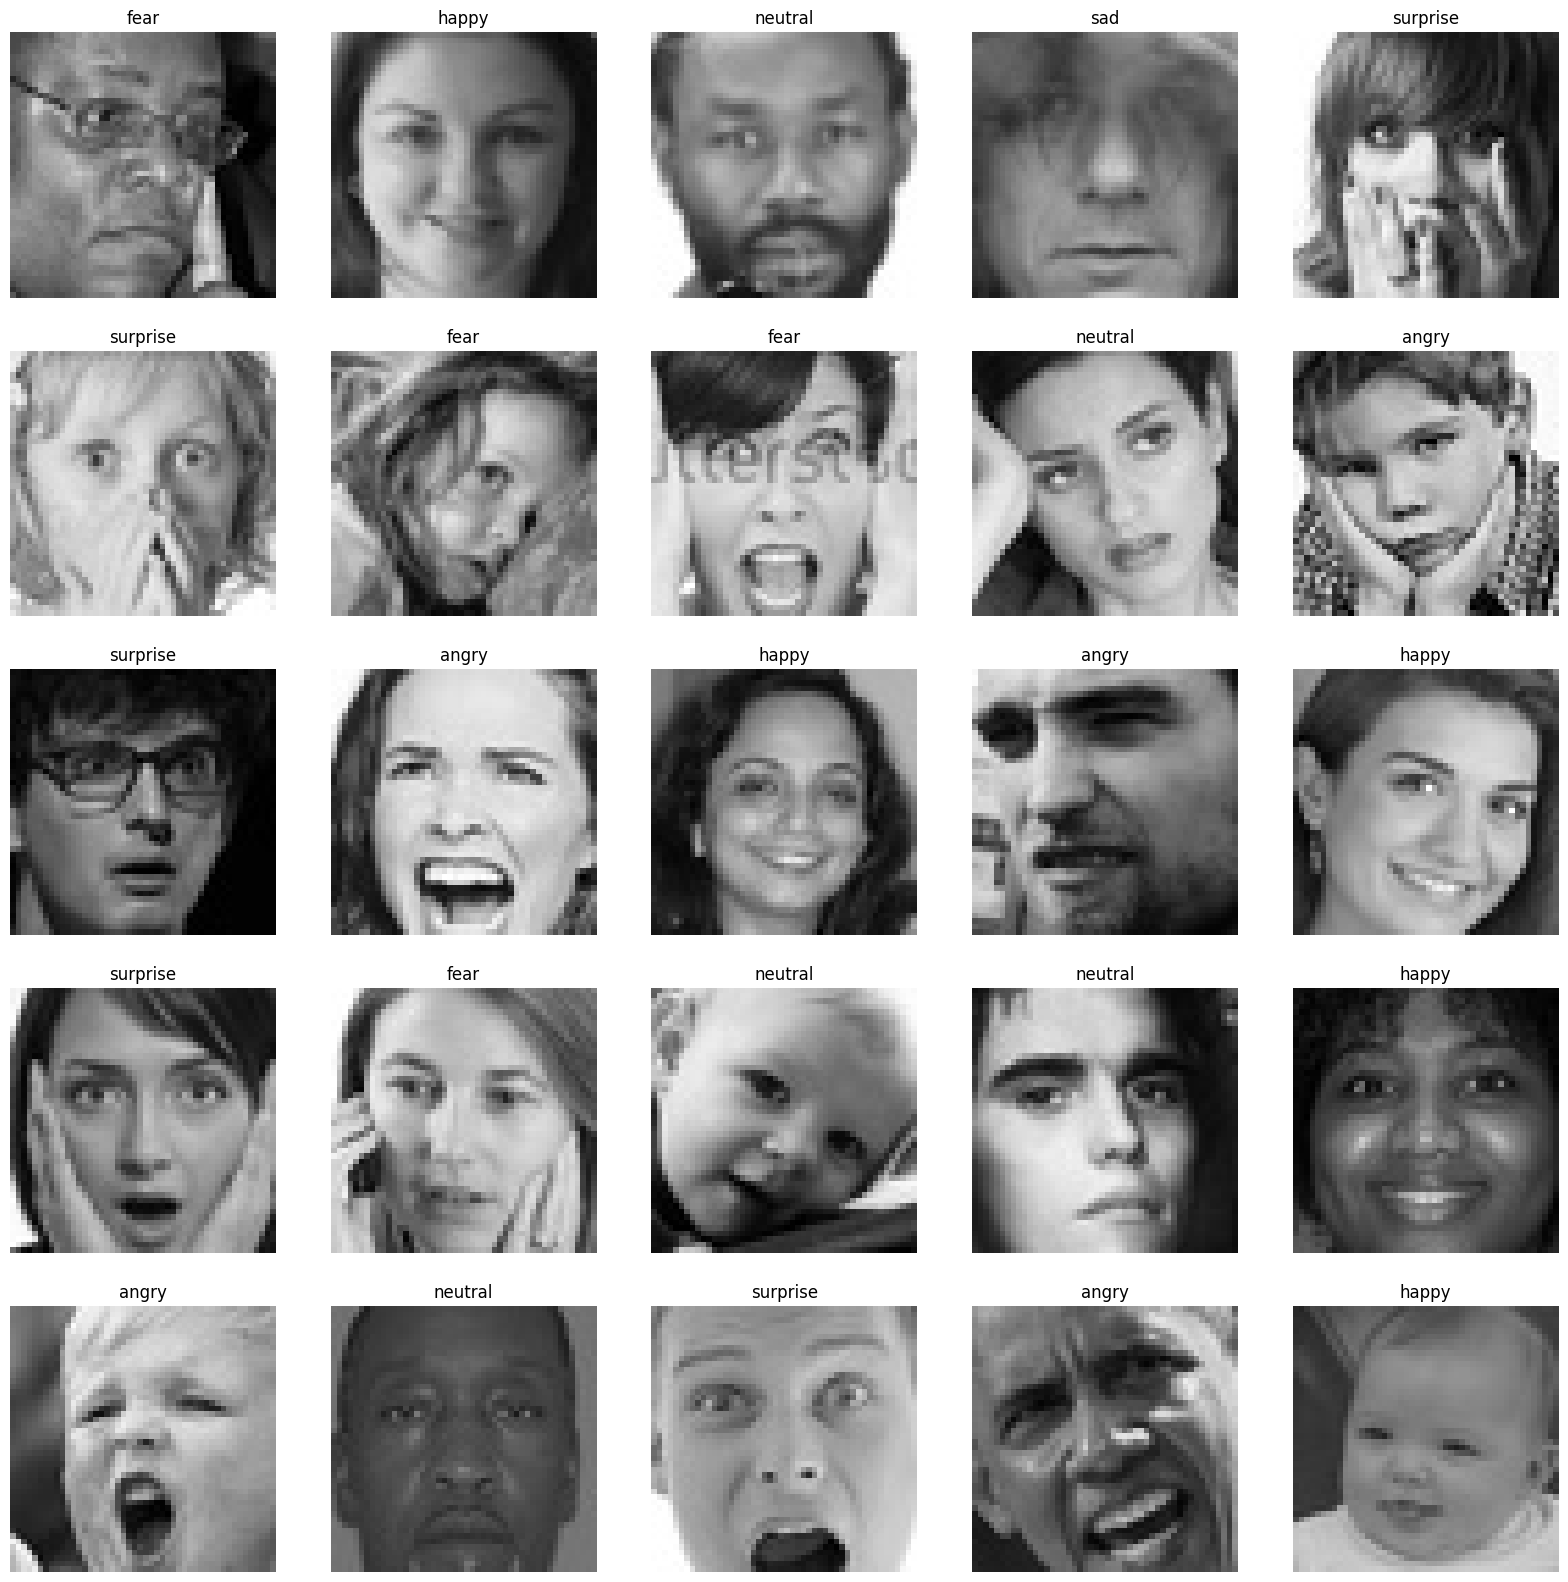

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
# convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(96, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(192, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(384, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
# fully connected layers
model.add(Dense(384, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
model.summary()
# train the model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 46, 46, 96)        960       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 23, 23, 96)        0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 23, 23, 96)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 21, 21, 192)       166080    
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 10, 10, 192)       0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 10, 10, 192)      

In [ ]:
history = model.fit(x=x_train, y=y_train, batch_size=144, epochs=100, validation_split = 0.3)

Epoch 1/100
141/141 [==============================] - 8s 45ms/step - loss: 1.8294 - accuracy: 0.2374 - val_loss: 1.7865 - val_accuracy: 0.2542
Epoch 2/100
141/141 [==============================] - 6s 42ms/step - loss: 1.7728 - accuracy: 0.2670 - val_loss: 1.6623 - val_accuracy: 0.3495
Epoch 3/100
141/141 [==============================] - 6s 42ms/step - loss: 1.6326 - accuracy: 0.3510 - val_loss: 1.5078 - val_accuracy: 0.4273
Epoch 4/100
141/141 [==============================] - 6s 42ms/step - loss: 1.5351 - accuracy: 0.3986 - val_loss: 1.4117 - val_accuracy: 0.4595
Epoch 5/100
141/141 [==============================] - 6s 43ms/step - loss: 1.4668 - accuracy: 0.4362 - val_loss: 1.3758 - val_accuracy: 0.4795
Epoch 6/100
141/141 [==============================] - 6s 43ms/step - loss: 1.4214 - accuracy: 0.4535 - val_loss: 1.3223 - val_accuracy: 0.5062
Epoch 7/100
141/141 [==============================] - 6s 42ms/step - loss: 1.3740 - accuracy: 0.4716 - val_loss: 1.2978 - val_accuracy:

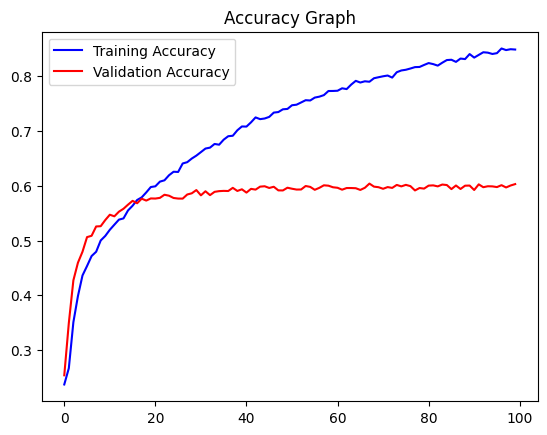

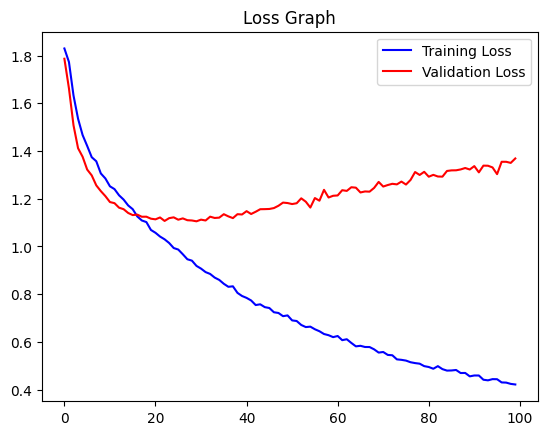

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [ ]:
(loss,acc) = model.evaluate(x_test, y_test)
print (round(acc*100,3), "%")

221/221 [==============================] - 1s 4ms/step - loss: 1.3807 - accuracy: 0.5985
59.85 %
